# Практична робота 9
Авдєєва Серафима ФІТ 4-4

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
num_classes = 10 # загальна кількість класів, у нашому випадку це цифри від 0 до 9
num_features = 784 # кількість атрибутів вхідного вектора 28*28 = 784
learning_rate = 0.001 # швидкість навчання нейронної мережі
training_steps = 3000 # максимальна кількість епох
batch_size = 256 # перераховувати ваги мережі ми будемо не на всій вибірці, а на її випадковому підтримці з batch_size елементів
display_step = 100 # кожні 100 ітерацій ми будемо показувати поточне значення функції втрат та точності
n_hidden_1 = 128 # кількість нейронів 1-го шару
n_hidden_2 = 256 # кількість нейронів 2-го шару

In [3]:
from tensorflow.keras.datasets import fashion_mnist
# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Перетворимо цілочисленні пікселі до типу float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворимо цілочисленні пікселі до типу float32
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

4422102/4422102 [==============================] - 0s 0us/step


In [4]:
# Створимо нейронну мережу

class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(
            tf.random.normal([in_features, out_features]), name="w"
        )
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation != 0:
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
  def __init__(self, name=None):
    super().__init__(name=name)
    # Перший шар, що складається із 128 нейронів.
    self.layer_1 = DenseLayer(in_features=num_features, out_features=n_hidden_1)

    # Другий шар, що складається з 256 нейронів
    self.layer_2 = DenseLayer(in_features=n_hidden_1, out_features=n_hidden_2)

    # Вихідний шар
    self.layer_3 = DenseLayer(in_features=n_hidden_2, out_features=num_classes)

  def __call__(self, x):

    x1 = self.layer_1(x, activation=0)
    x2 = self.layer_2(x1, activation=0)
    x3 = self.layer_3(x2, activation=1)

    return x3

In [5]:
# Як функцію помилки в даному випадку зручно взяти крос-ентропію
def cross_entropy(y_pred, y_true):
    # Encode label to a one hot vector.
    y_true = tf.one_hot(y_true, depth=num_classes)

    # Clip prediction values to avoid log(0) error.
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)

    # Обчислення крос-ентропії
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred)))

# Як метрику якості використовуємо точність
def accuracy(y_pred, y_true):
    # Місце для вашого коду
    acc = tf.metrics.Accuracy()
    acc.update_state(y_true, tf.argmax(y_pred, axis=1))
    return acc.result()

In [6]:
# Створимо екземпляр нейронної мережі
neural_net = NN(name="fashion_mnist")

# Функція навчання нейромережі
def train(nn, input_x, output_y):
  # Для припасування ваг мережі будемо використовувати стохастичний градієнтний спуск
  optimizer = tf.optimizers.SGD(learning_rate)

  # Активація автоматичного диференціювання
  with tf.GradientTape() as g:
    pred = neural_net(input_x)
    loss = cross_entropy(pred, output_y)

    # Створимо список параметрів, що оптимізуються.
    trainable_variables = nn.trainable_variables

    # Обчислимо за ними значення градієнта
    gradients = g.gradient(loss, trainable_variables)

    # Модифікуємо параметри
    optimizer.apply_gradients(zip(gradients, trainable_variables))

In [7]:
# Тренування мережі

loss_history = []
accuracy_history = []


for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps)):
    # Оновлюємо ваги нейронної мережі
    train(neural_net, batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)
        current_loss = cross_entropy(pred, batch_y)
        loss_history.append(current_loss)

        current_accuracy = accuracy(pred, batch_y)
        accuracy_history.append(current_accuracy)
        print(f"Step: {step}, Loss: {current_loss}, Accuracy: {current_accuracy}")

Step: 0, Loss: 2243.57958984375, Accuracy: 0.17578125
Step: 100, Loss: 266.961669921875, Accuracy: 0.6328125
Step: 200, Loss: 231.01332092285156, Accuracy: 0.6875
Step: 300, Loss: 261.162353515625, Accuracy: 0.6953125
Step: 400, Loss: 187.98062133789062, Accuracy: 0.73828125
Step: 500, Loss: 178.28041076660156, Accuracy: 0.76953125
Step: 600, Loss: 175.39195251464844, Accuracy: 0.78125
Step: 700, Loss: 208.54071044921875, Accuracy: 0.7265625
Step: 800, Loss: 126.92395782470703, Accuracy: 0.828125
Step: 900, Loss: 218.0441436767578, Accuracy: 0.734375
Step: 1000, Loss: 154.02792358398438, Accuracy: 0.8046875
Step: 1100, Loss: 94.6651611328125, Accuracy: 0.8671875
Step: 1200, Loss: 134.68057250976562, Accuracy: 0.80859375
Step: 1300, Loss: 111.07393646240234, Accuracy: 0.80078125
Step: 1400, Loss: 148.21148681640625, Accuracy: 0.80859375
Step: 1500, Loss: 162.47677612304688, Accuracy: 0.7578125
Step: 1600, Loss: 122.02495574951172, Accuracy: 0.82421875
Step: 1700, Loss: 115.5957489013671

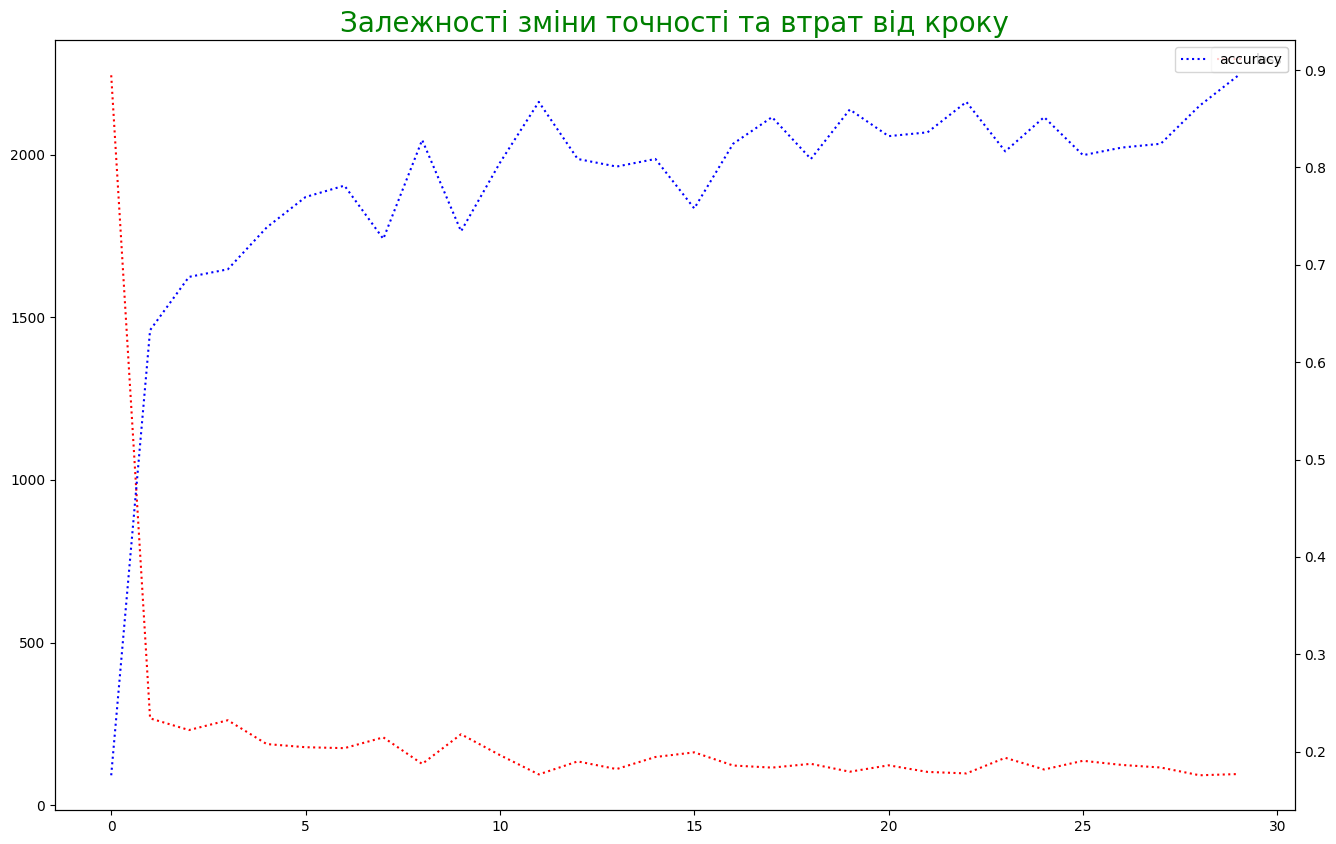

In [8]:
# Виводимо графіки залежності зміни точності та втрат від кроку

import pandas as pd

fig, axs = plt.subplots(figsize=(16, 10))
axs.plot(loss_history, 'r', label='loss', linestyle=":")
axs.legend()

axs2=axs.twinx()
axs2.plot(accuracy_history, 'b', label='accuracy', linestyle=":")
plt.legend()

plt.title('Залежності зміни точності та втрат від кроку', fontsize=20, color='g')
plt.show()

In [9]:
# Обчислюємо точність навченої нейромережі

neural_net_accuracy = accuracy(neural_net(x_train), y_train)
print(f"Accuracy: {neural_net_accuracy}")

Accuracy: 0.835183322429657


True: 1 Predict: 1 True
True: 0 Predict: 0 True
True: 2 Predict: 2 True
True: 1 Predict: 1 True
True: 2 Predict: 2 True
True: 9 Predict: 9 True
True: 1 Predict: 1 True
True: 3 Predict: 3 True
True: 1 Predict: 1 True
True: 0 Predict: 0 True


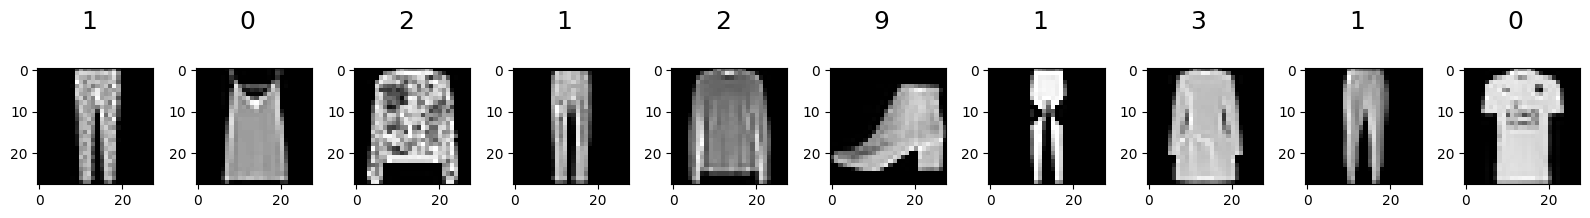

In [11]:
# Тестуємо навчену нейромережу на 10 зображеннях

test_img = np.random.permutation(x_test.shape[0])[:10]
y_test_true = y_test[test_img]
pred_data = [np.argmax(x) for x in neural_net(x_test[test_img])]

plt.figure(figsize=(16, 6))
for i in range(10):
    print(f"True: {y_test_true[i]} Predict: {pred_data[i]} {True if y_test_true[i] - pred_data[i] == 0 else False}")
    plt.subplot(1, 10, (i + 1))
    plt.imshow(x_test[test_img[i]].reshape(28, 28), cmap='gray')
    plt.text(x=10, y=-10, s=pred_data[i], fontsize=18)

plt.tight_layout()
plt.show()

# Висновок

У данному завданні була використана бібліотека TensorFlow для побудови нейронної мережі з низькорівневими механізмами. Задача полягала в класифікації типів одягу за допомогою датасету fashion_mnist. Обрані параметри нейронної мережі включають швидкість навчання (learning_rate), максимальну кількість епох (training_steps), розмір підбору (batch_size), крок відображення результатів (display_step), та кількість нейронів у кожному з двох прихованих шарів (n_hidden_1 і n_hidden_2).

Модель була побудована та навчена на вибірці даних. Після тренування була обчислена точність моделі, яка складає  0.835183322429657. Додатково були побудовані графіки функції втрат та точності для візуалізації процесу навчання. На графіку бачимо, що точність зростає, а втрати зменшуються, отже, попередні кроки виконано правильно. Також виведено 10 випадкових зображень з датасету fashion_mnist, разом з назвою класу та передбаченням моделі для кожного зображення. Усі передбачення для даних десяти зображень виявилися правильними.

Отже, в результаті виконання цього завдання була створена, навчена та оцінена нейронна мережа для класифікації типів одягу, а також проведено візуалізацію результатів навчання.